# LUSD Pool Model

In [59]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as md
from matplotlib import ticker
import scipy as scp
import scipy.optimize as opt
import csv
import math
import random
import pandas as pd
import copy
from datetime import datetime, timedelta
import pytz

## Core Idea
The core idea of a pool is a LUSD : staBAL pool, which utilizes StableSwap invariant and provides low slippage tool for swapping tokens equal in price. staBAL is a BPT token of Balancer stable pool with 3 stable tokens: USDC, USDT and DAI.

Such pool has a potential to be a high-profitable mining/income tool. That is because Balacner architecture allows to stake liquidity tokens of the pool into other pools and investing mechanisms, though still maintaining the pool as if all the tokens still remain in the pool. In other words, LUSD tokens from the pool could be staked into Liquidity Stability Pool for additional profit (with some reserve left in the original pool to maintain small swaps) and perform liquidity mining for the liquidity providers of the original pool. This profits will sum with the base profits from swap fees and liquidity provision in the original pool, effectively adding APRs.

# Pool Model Based on Previous Data

For LUSD part of the Pool, we take the existing data on operation of *Liquity* protocol from July 1st, 2021 to September 9th, 2021. The pool acts as if "it has always been there".

### LUSD operations

* LQTY rewards are calculated based on the Pool's share of LUSD in the Stability Pool. The amount of LQTY rewards is calculated as follows:

$$
\begin{align*}
& SP_{share} = \frac{LUSD_{Pool}^{i}}{LUSD_{StabilityPool}^{i}};\\
\\
& LQTY_{gained}^{i} = (LQTY_{total}^{i} - LQTY_{total}^{i-1})\times SP_{share},
\end{align*}
$$

where upper index $i$ denotes the timestamp of the calculation. The timestamps are exactly 1 hour difference, except the events of liquidations.

* Liquidation rewards are calculated basically the same way, taking into consideration the mathematics behind the collateral distibution and LUSD burning.

$$
\begin{align*}
& COL_{distributed}^{i} = COL_{liquidated}^{i}\times(1 - 0.05)\cdot100\%;\\
\\
& COL_{gained}^{i} = COL_{distributed}^{i}\times SP_{share}^{i};\\
\\
& LUSD_{lost}^{i} = LUSD_{burned}^{i}\times SP_{share}^{i}.
\end{align*}
$$

* Trades of LQTY token occur when a minimum resonable amount is collected in the Pool. It is almost impossible to account for slippage and trading fees, thus every trading operation is multiplyed by loss coefficient:

$$
\begin{align*}
& LUSD_{bought}^{i} = \frac{LQTY_{sold}^{i}\times{LQTY_price}^{i}}{LUSD_{price}^{i}}\times L; \hspace{3mm} L = 0.9
\end{align*}
$$


### staBAL operations

Balancer 3Pool token continuously grows in price due to fees accumulation.
This is taken into account in form of staBAL revenues adding back to the Pool. staBAL is concidered 1$.


* BAL rewards are concidered as follows:
  
$$
BAL_{gain} = BAL_{reward} * staBAL_{share}
$$

where staBAL share is otained similarly to LUSD SP pool.

### Creating Dataframes of Different Statistics

##### Creating timeframe

In [60]:
start_date = datetime(2021, 10, 1, 0, 0, 0) #1th of October, 2021, 00:00
start_date = pd.to_datetime(start_date, utc=True)

end_date = datetime(2021, 12, 25, 0, 0, 0) #1st of January, 2022, 00:00
end_date = pd.to_datetime(end_date, utc=True)

dateColumn = pd.date_range(start_date, end_date, freq='D')
dateColumn = pd.DataFrame(dateColumn, columns=['date'])
dateColumn

,date
0,2021-10-01 00:00:00+00:00
1,2021-10-02 00:00:00+00:00
2,2021-10-03 00:00:00+00:00
3,2021-10-04 00:00:00+00:00
4,2021-10-05 00:00:00+00:00
...,...
81,2021-12-21 00:00:00+00:00
82,2021-12-22 00:00:00+00:00
83,2021-12-23 00:00:00+00:00
84,2021-12-24 00:00:00+00:00


##### Creating LUSD dataframe

In [61]:
Total_LUSD_Supply = pd.read_csv('new_data/tmp/Total LUSD Supply.csv')
LUSD_Utilization = pd.read_csv('new_data/tmp/LUSD Utilization.csv')
LUSD = pd.DataFrame()

LUSD['date'] = pd.to_datetime(LUSD_Utilization['hour'])
LUSD['LUSD in SP'] = LUSD_Utilization['stabilityPool']
#LUSD['LUSD other'] = LUSD_Utilization.iloc[:, 1:].sum(1, numeric_only=True) - LUSD_Utilization['stabilityPool']

LUSD = LUSD.merge(right=dateColumn, on='date', how='right')
LUSD = LUSD.groupby(LUSD['date'].dt.date).mean().reset_index()
LUSD['date'] = pd.to_datetime(LUSD['date'], utc=True)
LUSD.head()

,date,LUSD in SP
0,2021-10-01 00:00:00+00:00,4.761356e+08
1,2021-10-02 00:00:00+00:00,4.759502e+08
2,2021-10-03 00:00:00+00:00,4.762005e+08
3,2021-10-04 00:00:00+00:00,4.903244e+08
4,2021-10-05 00:00:00+00:00,4.893468e+08


##### Creating LQTY dataframe

In [62]:
Total_LQTY_Staked = pd.read_csv('new_data/tmp/Total LQTY Staked.csv')

LQTY = pd.DataFrame()

LQTY['date'] = pd.to_datetime(Total_LQTY_Staked['hour'])
LQTY['LQTY staked'] = Total_LQTY_Staked['totalLQTYStaked']
LQTY['LQTY circulating'] = Total_LQTY_Staked['totalLQTYClaimed'] - Total_LQTY_Staked['totalLQTYStaked']
LQTY['LQTY total'] = Total_LQTY_Staked['totalLQTYClaimed']

LQTY = LQTY.merge(right=dateColumn, on='date', how='right')
LQTY = LQTY.fillna(method='bfill')
    
LQTY = LQTY.groupby(LQTY['date'].dt.date).mean().reset_index()
LQTY['date'] = pd.to_datetime(LQTY['date'], utc=True)

LQTY

,date,LQTY staked,LQTY circulating,LQTY total
0,2021-10-01 00:00:00+00:00,8.882722e+06,1.432107e+06,1.031483e+07
1,2021-10-02 00:00:00+00:00,9.048180e+06,1.324435e+06,1.037261e+07
2,2021-10-03 00:00:00+00:00,9.137008e+06,1.330987e+06,1.046799e+07
3,2021-10-04 00:00:00+00:00,9.143962e+06,1.360725e+06,1.050469e+07
4,2021-10-05 00:00:00+00:00,9.194320e+06,1.368012e+06,1.052384e+07
...,...,...,...,...
81,2021-12-21 00:00:00+00:00,1.156463e+07,1.960352e+06,1.350247e+07
82,2021-12-22 00:00:00+00:00,1.156463e+07,1.960352e+06,1.350247e+07
83,2021-12-23 00:00:00+00:00,1.156463e+07,1.960352e+06,1.352498e+07
84,2021-12-24 00:00:00+00:00,1.148202e+07,2.095845e+06,1.357787e+07


##### Creating Liquidations dataframe

In [63]:
Liquidations_ = pd.read_csv('new_data/tmp/Recent Liquidations.csv')

Liquidations = pd.DataFrame()

Liquidations['date'] = pd.to_datetime(Liquidations_['timestamp'])
Liquidations['LIQ col'] = Liquidations_['collateral']
Liquidations['LIQ debt'] = Liquidations_['debt']
Liquidations['LIQ price'] = Liquidations_['price']
Liquidations['LIQ CR'] = Liquidations_['collateralRatio']
Liquidations['LIQ mode'] = Liquidations_['mode']
        
Liquidations = Liquidations[(Liquidations['date'] >= start_date) & (Liquidations['date'] <= end_date)].merge(right=dateColumn, on='date', how='outer')
#Liquidations = Liquidations.merge(right=dateColumn, on='date', how='outer')
Liquidations.sort_values(by='date', ignore_index=True, inplace=True)
Liquidations.loc[:, 'LIQ col':'LIQ CR'] = Liquidations.loc[:, 'LIQ col':'LIQ CR'].fillna(value=0)
Liquidations.loc[:, 'LIQ mode'] = Liquidations.loc[:, 'LIQ mode'].fillna(value = 'none')
#Liquidations = Liquidations[Liquidations['LIQ col'] != 0]

Liquidations.head()

,date,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode
0,2021-10-01 00:00:00+00:00,0.0,0.0,0.0,0.0,none
1,2021-10-02 00:00:00+00:00,0.0,0.0,0.0,0.0,none
2,2021-10-03 00:00:00+00:00,0.0,0.0,0.0,0.0,none
3,2021-10-04 00:00:00+00:00,0.0,0.0,0.0,0.0,none
4,2021-10-05 00:00:00+00:00,0.0,0.0,0.0,0.0,none


##### Loading staBAL Data

In [64]:
staBAL_Revenue = pd.read_csv('new_data/tmp/staBAL Revenue.csv')
staBAL_Supply = pd.read_csv('new_data/tmp/staBAL Total Supply.csv')
staBAL_Rewards = pd.read_csv('new_data/tmp/staBAL Rewards2.csv')

staBAL_Supply = staBAL_Supply.rename(columns={'day':'date', 'daily_total_supply':'staBAL total supply'})
staBAL_Supply['date'] = pd.to_datetime(staBAL_Supply['date'], utc=True)
staBAL_Supply = staBAL_Supply.groupby(staBAL_Supply['date'].dt.date).mean().reset_index()
staBAL_Supply['date'] = pd.to_datetime(staBAL_Supply['date'], utc=True)

staBAL_Revenue = staBAL_Revenue.rename(columns={'day':'date', 'revenues':'staBAL revenues'}).drop(columns=['cumulative_revenues'])
staBAL_Revenue['date'] = pd.to_datetime(staBAL_Revenue['date'], utc=True)
staBAL_Revenue = staBAL_Revenue.groupby(staBAL_Revenue['date'].dt.date).sum().reset_index()
staBAL_Revenue['date'] = pd.to_datetime(staBAL_Revenue['date'], utc=True)

staBAL_Rewards = staBAL_Rewards.rename(columns={'week':'date', 'amount':'staBAL rewards'})[['date', 'staBAL rewards']]
staBAL_Rewards['date'] = pd.to_datetime(staBAL_Rewards['date'], utc=True)
staBAL_Rewards = staBAL_Rewards.groupby(staBAL_Rewards['date'].dt.date).sum().reset_index()
staBAL_Rewards['date'] = pd.to_datetime(staBAL_Rewards['date'], utc=True)

staBAL = pd.DataFrame()
staBAL['date'] = dateColumn
staBAL = staBAL.merge(right=staBAL_Supply, how='outer', on='date').fillna(method='ffill')
staBAL = staBAL.merge(right=staBAL_Rewards, how='outer', on='date')
staBAL = staBAL.merge(right=staBAL_Revenue, how='outer', on='date')

staBAL = staBAL.sort_values(by='date').fillna(value=0)
staBAL

,date,staBAL total supply,staBAL rewards,staBAL revenues
186,2021-01-11 00:00:00+00:00,0.000000e+00,15000.0,0.000000
187,2021-02-08 00:00:00+00:00,0.000000e+00,15000.0,0.000000
188,2021-04-10 00:00:00+00:00,0.000000e+00,15000.0,0.000000
189,2021-05-07 00:00:00+00:00,0.000000e+00,0.0,0.000000
190,2021-06-09 00:00:00+00:00,0.000000e+00,15000.0,0.000000
...,...,...,...,...
181,2022-01-02 00:00:00+00:00,1.687348e+08,0.0,1774.023360
182,2022-01-03 00:00:00+00:00,1.687754e+08,0.0,1349.860625
183,2022-01-04 00:00:00+00:00,1.688221e+08,0.0,1181.574586
184,2022-01-05 00:00:00+00:00,1.691325e+08,0.0,1664.491363


## Loading Prices

##### Loading ETH price

In [65]:
ETHprice = pd.read_csv('./new_data/ETH price.csv')
ETHprice.drop(ETHprice.loc[:, ['market_cap', 'total_volume']], axis=1, inplace=True)
ETHprice['snapped_at'] = pd.to_datetime(ETHprice['snapped_at'], utc=True )
ETHprice = ETHprice.sort_values(by='snapped_at', ascending=True, ignore_index=True)
ETHprice.rename(columns = {'snapped_at':'date', 'price':'ETH price'}, inplace=True)
ETHprice = ETHprice.merge(right=dateColumn, how='outer')
ETHprice = ETHprice[(ETHprice['date'] >= start_date) & (ETHprice['date'] <= end_date)].sort_values(by='date').reset_index(drop=True).fillna(method='ffill')
ETHprice = ETHprice.groupby(ETHprice['date'].dt.date).mean().reset_index()
ETHprice['date'] = pd.to_datetime(ETHprice['date'], utc=True)
ETHprice

,date,ETH price
0,2021-10-01 00:00:00+00:00,3013.493232
1,2021-10-02 00:00:00+00:00,3305.107041
2,2021-10-03 00:00:00+00:00,3393.924249
3,2021-10-04 00:00:00+00:00,3426.387081
4,2021-10-05 00:00:00+00:00,3390.310408
...,...,...
81,2021-12-21 00:00:00+00:00,3950.482392
82,2021-12-22 00:00:00+00:00,4036.549718
83,2021-12-23 00:00:00+00:00,3992.594577
84,2021-12-24 00:00:00+00:00,4113.529932


##### Loading BAL price

In [66]:
BALprice = pd.read_csv('./new_data/BAL price.csv')
BALprice = BALprice.loc[:, ('snapped_at', 'price')].rename(columns={'snapped_at': 'date', 'price':'BAL price'})
BALprice.loc[:, 'date'] = pd.to_datetime(BALprice['date'])
BALprice = BALprice.merge(right=dateColumn, how='outer', on='date')
BALprice = BALprice.sort_values(by='date', ignore_index=True)
BALprice = BALprice[(BALprice['date'] >= start_date) & (BALprice['date'] <= end_date)].fillna(method='ffill')
BALprice = BALprice.reset_index(drop=True)
BALprice = BALprice.groupby(BALprice['date'].dt.date).mean().reset_index()
BALprice['date'] = pd.to_datetime(BALprice['date'], utc=True)
BALprice

,date,BAL price
0,2021-10-01 00:00:00+00:00,19.748189
1,2021-10-02 00:00:00+00:00,21.704872
2,2021-10-03 00:00:00+00:00,22.389347
3,2021-10-04 00:00:00+00:00,22.773644
4,2021-10-05 00:00:00+00:00,21.843970
...,...,...
81,2021-12-21 00:00:00+00:00,18.187085
82,2021-12-22 00:00:00+00:00,18.593026
83,2021-12-23 00:00:00+00:00,17.974987
84,2021-12-24 00:00:00+00:00,19.181731


##### Loading LQTY Price

In [67]:
LQTYprice = pd.read_csv('./new_data/tmp/LQTY Price.csv')
LQTYprice = LQTYprice.loc[:, ('snapped_at', 'price')].rename(columns={'snapped_at':'date', 'price':'LQTY price'})
LQTYprice['date'] = pd.to_datetime(LQTYprice['date'])
LQTYprice = LQTYprice.merge(right=dateColumn, how='outer', on='date')
LQTYprice = LQTYprice.sort_values(by='date', ignore_index=True)
LQTYprice = LQTYprice[(LQTYprice['date'] >= start_date) & (LQTYprice['date'] <= end_date)].fillna(method='ffill')
LQTYprice = LQTYprice.reset_index(drop=True)
LQTYprice = LQTYprice.groupby(LQTYprice['date'].dt.date).mean().reset_index()
LQTYprice['date'] = pd.to_datetime(LQTYprice['date'], utc=True)
LQTYprice

,date,LQTY price
0,2021-10-01 00:00:00+00:00,4.713073
1,2021-10-02 00:00:00+00:00,5.141785
2,2021-10-03 00:00:00+00:00,5.217497
3,2021-10-04 00:00:00+00:00,5.058743
4,2021-10-05 00:00:00+00:00,5.043596
...,...,...
81,2021-12-21 00:00:00+00:00,6.033598
82,2021-12-22 00:00:00+00:00,6.016900
83,2021-12-23 00:00:00+00:00,6.148292
84,2021-12-24 00:00:00+00:00,6.524465


##### Loading Gas Prices

Gas Prices are loaded in ETH

In [68]:
Gas = pd.read_csv('./new_data/tmp/Gas Price.csv')
Gas = Gas.rename(columns={'dt':'date', 'median_gas_price_gwei':'Gas price'})
Gas['date'] = pd.to_datetime(Gas['date'])
Gas['Gas price'] /= 1e9
Gas

,date,Gas price
0,2021-04-20 00:00:00+00:00,2.640000e-07
1,2021-04-21 00:00:00+00:00,1.660000e-07
2,2021-04-22 00:00:00+00:00,1.342000e-07
3,2021-04-23 00:00:00+00:00,1.120000e-07
4,2021-04-24 00:00:00+00:00,6.396481e-08
...,...,...
266,2022-01-11 00:00:00+00:00,1.704316e-07
267,2022-01-12 00:00:00+00:00,1.628000e-07
268,2022-01-13 00:00:00+00:00,1.557791e-07
269,2022-01-14 00:00:00+00:00,1.617991e-07


## Loading Swaps on Curve and Uniswap

In [69]:
Curve_Swaps = pd.read_csv('./new_data/tmp/dex/LUSD-3CRV Swaps (100d) (2).csv')
Curve_Pool = pd.read_csv('./new_data/tmp/dex/LUSD-3CRV Pool (100d).csv')


Curve_Swaps['hour'] = pd.to_datetime(Curve_Swaps['hour'], utc=True)
Curve_Swaps = Curve_Swaps.rename(columns={'hour':'date'})
Curve_Swaps = Curve_Swaps[[c for c in Curve_Swaps.columns if c not in ['lusdDai', 'lusdUsdc', 'lusdUsdt']]].groupby(Curve_Swaps['date'].dt.date).sum().reset_index()
Curve_Swaps['Curve volume'] = abs(Curve_Swaps.loc[:, ['lusdIn', 'lusdOut']].sum(axis=1))
Curve_Swaps = Curve_Swaps[['date', 'Curve volume']]
Curve_Swaps['date'] = pd.to_datetime(Curve_Swaps['date'], utc=True)

Curve_Pool = Curve_Pool.rename(columns={'hour':'date'})
Curve_Pool['date'] = pd.to_datetime(Curve_Pool['date'], utc=True)
Curve_Pool = Curve_Pool.groupby(Curve_Pool['date'].dt.date).sum().reset_index()
Curve_Pool['Curve TVL'] = Curve_Pool['3crvBalance'] + Curve_Pool['lusdBalance']
Curve_Pool = Curve_Pool[['date', 'Curve TVL']]
Curve_Pool['date'] = pd.to_datetime(Curve_Pool['date'], utc=True)


Curve_Pool

,date,Curve TVL
0,2021-09-30 00:00:00+00:00,3.321547e+09
1,2021-10-01 00:00:00+00:00,3.132347e+09
2,2021-10-02 00:00:00+00:00,3.254024e+09
3,2021-10-03 00:00:00+00:00,3.056744e+09
4,2021-10-04 00:00:00+00:00,3.193079e+09
...,...,...
98,2022-01-06 00:00:00+00:00,3.287459e+09
99,2022-01-07 00:00:00+00:00,3.685706e+09
100,2022-01-08 00:00:00+00:00,3.893160e+09
101,2022-01-09 00:00:00+00:00,2.450752e+09


### Merging All Data into Single Dataframe


##### Creating main dataframe and merging info

In [70]:
Data = pd.DataFrame()
Data = copy.deepcopy(dateColumn)

Data = Data.merge(LUSD, how='outer', on='date')
Data = Data.merge(LQTY, how='outer', on='date')
Data = Data.merge(Liquidations, how='outer', on='date')
Data = Data.merge(ETHprice.loc[:, ['date', 'ETH price']], on='date', how='outer')
Data = Data.merge(BALprice, on='date', how='outer')
Data = Data.merge(LQTYprice, on='date', how='outer')
Data = Data.merge(staBAL, on='date', how='outer')
Data = Data.merge(Gas, on='date', how='outer')
Data = Data.merge(Curve_Swaps, on='date', how='outer')
Data = Data.merge(Curve_Pool, on='date', how='outer')

Data = Data[(Data['date'] >= start_date) & (Data['date'] <= end_date)]
Data = Data.sort_values(by=['date'], ignore_index=True).reset_index(drop=True)#.fillna(method='ffill')

#Data[['ETH price', 'BAL price', 'LQTY Price']] = Data[['ETH price', 'BAL price', 'LQTY Price']].fillna(method='ffill')
#Data[['ETH price', 'BAL price', 'LQTY Price']] = Data[['ETH price', 'BAL price', 'LQTY Price']].fillna(method='bfill')
#Data[Data.columns.drop(['ETH price', 'LIQ mode'])] = Data[Data.columns.drop(['ETH price', 'LIQ mode'])].fillna(method='ffill')

for c in ['LUSD in SP', 'LQTY staked', 'LQTY circulating', 'LQTY total', 'ETH price', 'BAL price', 'LQTY price', 'staBAL total supply', 'Gas price', 'Curve TVL']:
    Data[c].fillna(method='ffill', inplace=True)



for c in ['staBAL rewards', 'staBAL revenues', 'Curve volume']:
    Data[c].fillna(value=0, inplace=True)

Data

,date,LUSD in SP,LQTY staked,LQTY circulating,LQTY total,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode,ETH price,BAL price,LQTY price,staBAL total supply,staBAL rewards,staBAL revenues,Gas price,Curve volume,Curve TVL
0,2021-10-01 00:00:00+00:00,4.761356e+08,8.882722e+06,1.432107e+06,1.031483e+07,0.0,0.0,0.0,0.0,none,3013.493232,19.748189,4.713073,1.551918e+08,0.0,2339.924011,8.196535e-08,7.202445e+06,3.132347e+09
1,2021-10-02 00:00:00+00:00,4.759502e+08,9.048180e+06,1.324435e+06,1.037261e+07,0.0,0.0,0.0,0.0,none,3305.107041,21.704872,5.141785,1.483776e+08,0.0,2332.204106,6.000000e-08,2.453969e+06,3.254024e+09
2,2021-10-03 00:00:00+00:00,4.762005e+08,9.137008e+06,1.330987e+06,1.046799e+07,0.0,0.0,0.0,0.0,none,3393.924249,22.389347,5.217497,1.481785e+08,0.0,915.121321,5.749070e-08,1.024413e+07,3.056744e+09
3,2021-10-04 00:00:00+00:00,4.903244e+08,9.143962e+06,1.360725e+06,1.050469e+07,0.0,0.0,0.0,0.0,none,3426.387081,22.773644,5.058743,1.520661e+08,0.0,3263.911549,8.800000e-08,8.566688e+06,3.193079e+09
4,2021-10-05 00:00:00+00:00,4.893468e+08,9.194320e+06,1.368012e+06,1.052384e+07,0.0,0.0,0.0,0.0,none,3390.310408,21.843970,5.043596,1.550288e+08,0.0,1223.884968,1.071797e-07,1.249371e+07,2.815679e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2021-12-21 00:00:00+00:00,5.086990e+08,1.156463e+07,1.960352e+06,1.350247e+07,0.0,0.0,0.0,0.0,none,3950.482392,18.187085,6.033598,1.383435e+08,0.0,1283.554068,6.539895e-08,5.453743e+06,1.785775e+09
101,2021-12-22 00:00:00+00:00,4.879745e+08,1.156463e+07,1.960352e+06,1.350247e+07,0.0,0.0,0.0,0.0,none,4036.549718,18.593026,6.016900,1.482333e+08,0.0,1142.736014,7.300000e-08,3.296764e+07,1.779676e+09
102,2021-12-23 00:00:00+00:00,4.934577e+08,1.156463e+07,1.960352e+06,1.352498e+07,0.0,0.0,0.0,0.0,none,3992.594577,17.974987,6.148292,1.481116e+08,0.0,1785.531069,7.711579e-08,8.000293e+07,2.291118e+09
103,2021-12-24 00:00:00+00:00,4.538873e+08,1.148202e+07,2.095845e+06,1.357787e+07,0.0,0.0,0.0,0.0,none,4113.529932,19.181731,6.524465,1.477543e+08,0.0,1040.567491,6.568008e-08,3.755339e+07,2.218690e+09


## Initializing Pool with 50/50 $ 60M Total TVL

### Creating a Pool Dataframe

In [85]:
Pool = pd.DataFrame()
    #columns = ['date', 'LUSD', 'staBAL', 'LQTY', 'ETH', 'SP share', 'ETH received', 'BAL received']
    #)

Pool['date'] = Data['date']

Pool.loc[:, 'LUSD'] = 30e6 #LUSD in Pool
Pool.loc[:, 'staBAL'] = 30e6 #staBAL in Pool (in US Dollars)
Pool.loc[:, 'LQTY'] = 0 #LQTY Rewards collected, but not withdrawn
Pool.loc[:, 'BAL'] = 0 #BAL Rewards collected, but not withdrawn
Pool.loc[:, 'SP share'] = 0 #Stability Pool share
Pool.loc[:, 'staBAL share'] = 0 #Balancer Stable Pool share
Pool.loc[:, 'ETH'] = 0 #ETH Rewards collected, but not withdrawn
Pool.loc[:, 'ETH received'] = 0 #ETH received at the timestamp
Pool.loc[:, 'ETH sold'] = 0 #ETH sold at the timestamp
Pool.loc[:, 'BAL received'] = 0 #BAL received at the timestamp
Pool.loc[:, 'BAL sold'] = 0 #BAL sold at the timestamp
Pool.loc[:, 'LQTY received'] = 0 #LQTY received at the timestamp
Pool.loc[:, 'LQTY sold'] = 0 #LQTY sold at the timestamp
Pool.loc[:, 'Gas spent'] = 0 #Amount in US Dollars payed for gas at the timestamp
Pool.loc[:, 'LQTY reserve'] = 0
Pool.loc[:, 'Trading income'] = 0
Pool.loc[:, 'Trading fees'] = 0
Pool.loc[:, 'BAL gas'] = 0
Pool.loc[:, 'ETH gas'] = 0
Pool.loc[:, 'LQTY gas'] = 0
Pool.loc[:, 'SP gas'] = 0
Pool.sort_values('date', ignore_index=True, inplace=True)

Pool

,date,LUSD,staBAL,LQTY,BAL,SP share,staBAL share,ETH,ETH received,ETH sold,...,LQTY received,LQTY sold,Gas spent,LQTY reserve,Trading income,Trading fees,BAL gas,ETH gas,LQTY gas,SP gas
0,2021-10-01 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-10-02 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-10-03 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-10-04 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-10-05 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2021-12-21 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,2021-12-22 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,2021-12-23 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,2021-12-24 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Operations Gas Requirement

We take into account the gas price for such operations like ETH, BAL and LQTY withdrawal and Stability Pool liquidity provision.
The respective gas estimations for these operations are:

* SP add liquidity: 300,000
* ETH withdrawal: 500,000
* LQTY withdrawal: 350,000
* BAL withdrawal: 100,000
* Trading operation: 1% fee + gas

In [88]:
for i in range(len(Pool)):

    Pool.loc[i, 'SP share'] = Pool['LUSD'][i] / Data['LUSD in SP'][i]
    Pool.loc[i, 'staBAL share'] = Pool['staBAL'][i] / Data['staBAL total supply'][i]
    
    if (i > 0):
        Pool.loc[i, 'LUSD'] = Pool['LUSD'][i-1]   
        Pool.loc[i, 'ETH'] = Pool['ETH'][i-1]
        Pool.loc[i, 'staBAL'] = Pool['staBAL'][i-1]
        Pool.loc[i, 'LQTY'] = Pool['LQTY'][i-1]
        Pool.loc[i, 'BAL'] = Pool['BAL'][i-1]
        Pool.loc[i, 'LQTY reserve'] = Pool['LQTY reserve'][i-1]
        
    
    
    if (Data['LIQ mode'][i] != 'none'): #Processing liquidation gains
        ETH_received = Data['LIQ col'][i]*(1-0.005)*Pool['SP share'][i]
        LUSD_lost = Data['LIQ debt'][i]*Pool['SP share'][i]
        Pool.loc[i, 'ETH received'] = ETH_received
        Pool.loc[i, 'ETH'] += ETH_received
        Pool.loc[i, 'LUSD'] -= LUSD_lost
        
    else:
        
        #checking if any ETH is on the account

        #ETH withdraw gas: 500,000 gwei
        #LUSD deposit gas: 300,000 gwei

        gas_price = Data['Gas price'][i] * Data['ETH price'][i]
        ETH_in_pool = Pool['ETH'][i] * Data['ETH price'][i]

        if (ETH_in_pool >= 10 * 500000 * gas_price):

            ETH_sold = Pool['ETH'][i] - 500000 * gas_price / Data['ETH price'][i] #approx. 500,000 gas is spent to withdraw ETH rewards to eth address

            if (ETH_sold <= 0):
                print('ETH sold < 0', ETH_sold, gas_price)
                break

            Pool.loc[i, 'Gas spent'] += 500000 * gas_price

            LUSD_bought = ETH_sold*Data['ETH price'][i] * (1 - 0.01) #1% trading fee
            Pool.loc[i, 'Trading fees'] += ETH_sold*Data['ETH price'][i] * 0.01
            Pool.loc[i, 'ETH'] = 0
            Pool.loc[i, 'ETH sold'] = ETH_sold
            Pool.loc[i, 'LUSD'] += LUSD_bought - 300000 * gas_price
            Pool.loc[i, 'Gas spent'] += 300000 * gas_price
            Pool.loc[i, 'ETH gas'] += 300000 * gas_price

        #checking if we have enough revenue (BAL tokens) to seel and add liquidity to the pool
        if (Pool['BAL'][i] >= 10 * 100000 * gas_price):

            BAL_sold = Pool['BAL'][i] - 100000 * gas_price / Data['BAL price'][i]

            if (BAL_sold <= 0):
                print('BAL sold < 0')
                break

            Pool.loc[i, 'Gas spent'] += 100000 * gas_price
            Pool.loc[i, 'BAL gas'] += 100000 * gas_price

            staBAL_bought = BAL_sold * Data['BAL price'][i] * (1 - 0.01) #1% trading fee
            Pool.loc[i, 'Trading fees'] += BAL_sold * Data['BAL price'][i] * 0.01
            Pool.loc[i, 'staBAL'] += staBAL_bought
            Pool.loc[i, 'BAL'] = 0
            Pool.loc[i, 'BAL sold'] = BAL_sold

        #checking if any LQTY is on the account

        if (Pool['LQTY'][i] > 10 * 350000 * gas_price):

            LQTY_sold = Pool['LQTY'][i] - 350000 * gas_price / Data['LQTY price'][i]
            if (LQTY_sold <= 0):
                print('LQTY sold < 0')
                break

            Pool.loc[i, 'Gas spent'] += 350000 * gas_price
            Pool.loc[i, 'LQTY gas'] += 350000 * gas_price
            LUSD_bought = LQTY_sold*Data['LQTY price'][i] * (1 - 0.01)

            Pool.loc[i, 'Trading fees'] += LQTY_sold*Data['LQTY price'][i] * 0.01
            Pool.loc[i, 'LQTY'] = 0
            Pool.loc[i, 'LUSD'] += LUSD_bought - 300000 * gas_price
            Pool.loc[i, 'SP gas'] += 300000 * gas_price
            Pool.loc[i, 'Gas spent'] += 300000 * gas_price
            Pool.loc[i, 'LQTY sold'] = LQTY_sold

        #calculating hypothetical trading volume fees
        Trading_volume_income = (Pool['LUSD'][i] + Pool['staBAL'][i])/Data['Curve TVL'][i] * Data['Curve volume'][i] * 0.004/100
        Pool.loc[i, 'staBAL'] += Trading_volume_income / 2
        Pool.loc[i, 'LUSD'] += Trading_volume_income / 2
        Pool.loc[i, 'Trading income'] += Trading_volume_income
        
            
        
        if (i > 0):
            
            #calculating LQTY reward
            
            LQTY_minted = Data['LQTY total'][i] - Data['LQTY total'][i-1]
            Pool.loc[i, 'LQTY'] += LQTY_minted*Pool['SP share'][i] * 0.85
            Pool.loc[i, 'LQTY received'] = LQTY_minted*Pool['SP share'][i]
            Pool.loc[i, 'LQTY reserve'] += LQTY_minted*Pool['SP share'][i] * 0.15

            #calculating staBAL revenue
            fees = Data['staBAL revenues'][i]*Pool['staBAL share'][i]
            Pool['staBAL'] += fees

            #calculating BAL rewards
            BAL_received = Data['staBAL rewards'][i] * Pool['staBAL share'][i]
            Pool.loc[i, 'BAL received'] = BAL_received
            Pool.loc[i, 'BAL'] += BAL_received

            
Pool     

,date,LUSD,staBAL,LQTY,BAL,SP share,staBAL share,ETH,ETH received,ETH sold,...,LQTY received,LQTY sold,Gas spent,LQTY reserve,Trading income,Trading fees,BAL gas,ETH gas,LQTY gas,SP gas
0,2021-10-01 00:00:00+00:00,3.000001e+07,3.011929e+07,0.000000,0.0,0.063007,0.193692,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,11.042473,0.000000,0.00000,0.0,0.000000,0.000000
1,2021-10-02 00:00:00+00:00,3.000001e+07,3.011929e+07,3095.969793,0.0,0.063032,0.202587,0.0,0.0,0.0,...,3642.317403,0.000000,0.000000,546.347610,3.621635,0.000000,0.00000,0.0,0.000000,0.000000
2,2021-10-03 00:00:00+00:00,3.001588e+07,3.011930e+07,5110.693526,0.0,0.063038,0.202863,0.0,0.0,0.0,...,6012.580618,3082.880819,253.654824,1448.234703,16.099065,350.204095,0.00000,0.0,136.583367,117.071457
3,2021-10-04 00:00:00+00:00,3.004128e+07,3.011930e+07,1911.342839,0.0,0.061283,0.197678,0.0,0.0,0.0,...,2248.638634,5089.832073,391.978689,1785.530498,12.894045,560.397767,0.00000,0.0,211.065448,180.913241
4,2021-10-05 00:00:00+00:00,3.005059e+07,3.011930e+07,1000.179379,0.0,0.061428,0.193904,0.0,0.0,0.0,...,1176.681623,1886.126634,472.384192,1962.032742,21.329094,207.085643,0.00000,0.0,254.360719,218.023473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2021-12-21 00:00:00+00:00,3.126488e+07,3.066157e+07,4193.330875,0.0,0.061833,0.221586,0.0,0.0,0.0,...,4933.330442,2549.604771,387.536103,28646.431953,15.144739,1542.957635,51.67148,0.0,180.850182,155.014441
101,2021-12-22 00:00:00+00:00,3.128969e+07,3.066159e+07,0.000000,0.0,0.064516,0.206805,0.0,0.0,0.0,...,0.000000,4176.190181,383.068568,28646.431953,91.902428,533.353236,0.00000,0.0,206.267691,176.800878
102,2021-12-23 00:00:00+00:00,3.128973e+07,3.066164e+07,1220.478020,0.0,0.063800,0.206976,0.0,0.0,0.0,...,1435.856495,0.000000,0.000000,28861.810427,173.236923,0.000000,0.00000,0.0,0.000000,0.000000
103,2021-12-24 00:00:00+00:00,3.129746e+07,3.066166e+07,3119.183648,0.0,0.069381,0.207480,0.0,0.0,0.0,...,3669.627822,1205.984580,351.230053,29412.254600,83.983715,167.009136,0.00000,0.0,189.123875,162.106178


### Results

Let us look at the results of the model:

##### Gains:

In [87]:
Init_TVL = Pool.iloc[0]['LUSD'] + Pool.iloc[0]['staBAL']
Final_TVL = Pool.iloc[-1]['LUSD'] + Pool.iloc[-1]['staBAL']

Total_Gain = (Final_TVL - Init_TVL) / Init_TVL

Total_APR = Total_Gain / len(Pool) * 365

LUSD_gain = Pool.iloc[-1]['LUSD'] - Pool['LUSD'][0]
staBAL_gain = (Pool.iloc[-1]['staBAL'] - Pool['staBAL'][0])

LUSD_percentage = LUSD_gain/Pool.iloc[0]['LUSD']
staBAL_percentage = staBAL_gain/Pool.iloc[0]['staBAL']

timeDelta = Pool.iloc[-1]['date'] - Pool.iloc[0]['date']
year = pd.to_timedelta(timedelta(days=365))

LUSD_APR = LUSD_percentage*year/timeDelta
staBAL_APR = staBAL_percentage*year/timeDelta


print('Initial TVL: {}'.format(Init_TVL), 'Final_TVL: {}'.format(Final_TVL))
print('Gain: {}'.format(Total_Gain))
print('LUSD APR: {:0,.3f}'.format(LUSD_APR))
print('staBAL APR: {:0,.3f}'.format(staBAL_APR))
print('Total APR:', Total_APR)

Initial TVL: 60059408.63174248 Final_TVL: 62109574.60907787
Gain: 0.0341356337673269
LUSD APR: 0.217
staBAL APR: 0.077
Total APR: 0.11866196500070782


##### Details:

* LQTY reward gains:

In [74]:
LQTY_gains = (Pool['LQTY received'] * Data['LQTY price']).sum()
print('LQTY gains: LQTY {} (${})'.format(Pool['LQTY received'].sum(), LQTY_gains))
LQTY_sold_total = (Pool['LQTY sold'] * Data['LQTY price']).sum()
print('LQTY sold: LQTY {} (${})'.format(Pool['LQTY sold'].sum(), LQTY_sold_total))

LQTY gains: LQTY 191700.14860647518 ($1523411.874134492)
LQTY sold: LQTY 162107.85809949058 ($1293346.6113124546)


In [93]:
Pool.iloc[-1]['LQTY reserve'] * Data.iloc[-1]['LQTY price']

188504.29089634126

* ETH (liquidations) gains:

In [75]:
ETH_gains = (Pool['ETH received']*Data['ETH price']).sum()
print('ETH gains: ETH {} (${})'.format(Pool['ETH received'].sum(), ETH_gains))
ETH_sold_total = (Pool['ETH sold'] * Data['ETH price']).sum()
print('ETH sold: ETH {} (${})'.format(Pool['ETH sold'].sum(), ETH_sold_total))

ETH gains: ETH 26.65636637672017 ($109446.10059748692)
ETH sold: ETH 26.38321521849542 ($107197.90583093608)


In [76]:
LQTY_gains + ETH_gains

1632857.9747319787

* BAL gains:

In [77]:
BAL_gains = (Pool['BAL received']*Data['BAL price']).sum()
print('BAL gains: BAL {} (${})'.format(Pool['BAL received'].sum(), BAL_gains))
BAL_sold_total = (Pool['BAL sold'] * Data['BAL price']).sum()
print('BAL sold: BAL {} (${})'.format(Pool['BAL sold'].sum(), BAL_sold_total))

BAL gains: BAL 27257.862943075354 ($556873.4475354876)
BAL sold: BAL 27237.883858206245 ($541464.5448288916)


* Total reward gains:

In [78]:
Total_reward_gains = LQTY_gains + ETH_gains + BAL_gains
print('Total reward gains: {}'.format(Total_reward_gains))

Total reward gains: 2189731.4222674663


* Gas spent on technical transactons (estimated):

In [79]:
Gas_spendings = (Pool['Gas spent'] + Pool['Trading fees']).sum()
print('Gas spent: ${}'.format(Gas_spendings))

Gas spent: $33289.140774712265


In [80]:
Pool['Gas spent'].sum()

13869.050154989443

In [81]:
(Data['staBAL revenues']*Pool['staBAL share']).sum()

59855.44203011343

In [82]:
Total_Gain_Rewards = (Pool['LQTY received']*Data['LQTY price']).sum() + (Pool['BAL received']*Data['BAL price']).sum()
print('Rewards gain (USD):', Total_Gain_Rewards)

Rewards gain (USD): 2080285.3216699795


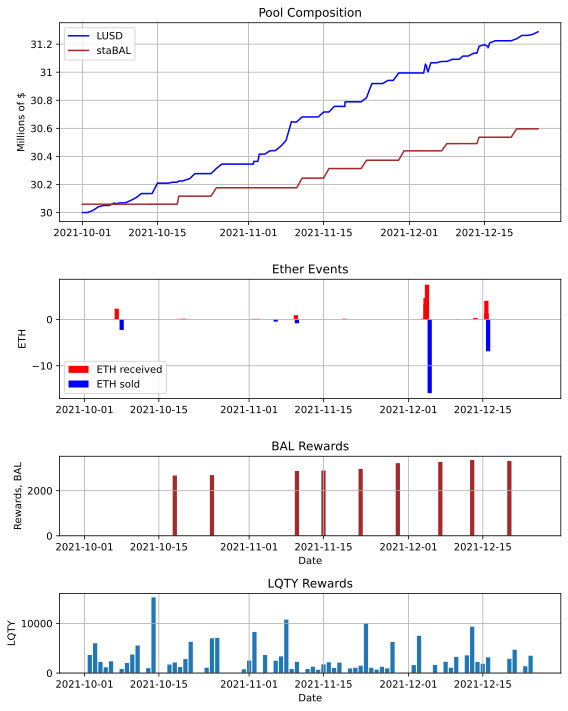

In [83]:
%config InlineBackend.figure_format='svg'
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [5,3,2,2]})
fig = plt.gcf()

dates = np.arange(0, len(Pool), 48)
date_ticks = [Pool['date'][i] for i in dates]

plot = ax1.plot(Pool['date'], Pool['LUSD'], color='blue')
plot = ax1.plot(Pool['date'], Pool['staBAL'], color='brown')
ax1.legend(('LUSD', 'staBAL'))
ax1.grid()
ax1.set_title('Pool Composition')
#ax1.set_xlabel('Date')
ax1.set_ylabel('Millions of $')

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

ax2.bar(Pool['date'], Pool['ETH received'], color='red', label='ETH received')
ax2.bar(Pool['date'], -Pool['ETH sold'], color='blue', label='ETH sold')
ax2.set_title('Ether Events')
ax2.set_ylabel('ETH')
#ax2.set_xlabel('Date')
ax2.legend()
ax2.grid()

ax3.bar(Data['date'], Data['staBAL rewards']*Pool['staBAL share'], color='brown')
ax3.set_title('BAL Rewards')
ax3.set_ylabel('Rewards, BAL')
ax3.set_xlabel('Date')
ax3.grid()

ax4.bar(Pool['date'], Pool['LQTY received'])
ax4.set_title('LQTY Rewards')
ax4.set_ylabel('LQTY')
ax4.set_xlabel('Date')
ax4.grid()

fig.set_size_inches(8, 10)
plt.tight_layout()